In [2]:
#importing sys
import sys
  
# adding src to the system path
sys.path.insert(0, '../src')

In [ ]:
'''This setting revolves around three model types: stat (statistical model), 1col (singlecolumn model), and ts (time-series model). The script uses a dictionary data_dict to
manage different data cuts, and a function evaluate_model is defined to evaluate each
model's performance. The function accepts parameters like the model type, training data,
test data, window parameters, feature extraction function, and a threshold for
classification. It prepares the data through a processing_pipeline and trains the respective
model based on the model type, using functions train_traditional_model,
train_series_model, or train_multiseries_model.The performance of each model is
evaluated based on metrics such as accuracy, AUC (Area Under the Curve), PR-AUC
(Precision-Recall AUC), F1 score, the number of windows, and lag.'''
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score

from ml_pipeline.model import processing_pipeline, test_model
from ml_pipeline.featureset import make_summary_stats_input, make_series_input
from ml_pipeline.model import train_traditional_model, train_series_model, train_multiseries_model

# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Dictionary to store all the data cuts we will create
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

def evaluate_model(model_type, train_data, test_data, window_kwargs, feature_func, add_first_diffs, threshold=0.5):
    """
    Evaluates the model.

    model_type: str, one of 'stat', '1col', 'ts' to indicate the model type
    train_data: The data to train the model on (train or test slice of the dataset)
    test_data: The data to test the model on (test slice of the dataset)
    window_kwargs: A dictionary with window parameters for processing
    feature_func: The feature function to use (e.g., make_summary_stats_input, make_series_input)
    add_first_diffs: Boolean, whether to add first differences to the data
    threshold: float, decision threshold for classification
    """
    # Prepare the data using the processing pipeline for both training and testing sets
    X_train, y_train = processing_pipeline(
        train_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    X_test, y_test = processing_pipeline(
        test_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    # Calculate number of windows and lag
    num_windows = len(X_train)
    lag = window_kwargs['window_length']

    # Train the model
    if model_type == 'stat':
        model = train_traditional_model(X=X_train.values, y=y_train.values)
    elif model_type == '1col':
        model = train_series_model(X=X_train, y=y_train)
    elif model_type == 'ts':
        model = train_multiseries_model(X=X_train, y=y_train)

    # Predict and calculate performance using the provided test_model function
    test_results = test_model(X_test, y_test.values, model, threshold=threshold)

    # Calculate additional metrics: accuracy, AUC, F1-score
    accuracy = accuracy_score(test_results['y_true'], test_results['y_pred'])
    auc = roc_auc_score(test_results['y_true'], test_results['class_1'])
    f1 = f1_score(test_results['y_true'], test_results['y_pred'])

    # Generate classification report for the model's performance
    report = classification_report(y_test.values, test_results['y_pred'], output_dict=True)
    
    # Compile results into a dictionary
    evaluation_results = {
        'classification_report': report,
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'num_windows': num_windows,
        'lag': lag
    }
    
    return evaluation_results

# Main execution to evaluate each model
results = {}

# Fix threshold to 0.5
threshold = 0.5

# Hyperparameter tuning for window_length and fh
window_length_candidates = [10, 20, 30]  # Adjust these values as needed
fh_candidates = [2, 5, 10, 20]  # Include specific fh values you are interested in

# Initialize variables to track the best performing model across all types
best_model = None
best_window_length = None
best_fh = None
best_f1_score = 0.0

# Loop through different model types, window lengths, and fh values
for model_type in ['stat', '1col', 'ts']:
    print(f"\nEvaluating '{model_type}' model")
    for window_length in window_length_candidates:
        for fh in fh_candidates:
            window_kwargs = {'window_length': window_length, 'step_length': 1, 'fh': fh}
            print(f"  Window length = {window_length}, Forecast Horizon (fh) = {fh}")
            
            # Adjust feature function and first differences based on model type
            if model_type == 'stat':
                feature_func = make_summary_stats_input
                add_first_diffs = False
            elif model_type == '1col':
                feature_func = make_series_input
                add_first_diffs = False
            elif model_type == 'ts':
                feature_func = make_series_input
                add_first_diffs = True
            
            # Evaluate the model
            model_results = evaluate_model(
                model_type=model_type,
                train_data=train[-3100:-2900],
                test_data=test[4200:4400],
                window_kwargs=window_kwargs,
                feature_func=feature_func,
                add_first_diffs=add_first_diffs,
                threshold=threshold
            )
            
            # Update best model tracking if this is the best F1 score so far
            if model_results['f1_score'] > best_f1_score:
                best_f1_score = model_results['f1_score']
                best_model = model_type
                best_window_length = window_length
                best_fh = fh
            
            # Store the results
            results[f'{model_type}_window_{window_length}_fh_{fh}'] = model_results

# Generate output tables for each fh value
output_tables = {}

for fh in fh_candidates:
    results_table = pd.DataFrame(columns=['Model', 'Window Size', 'AUC', 'F1', 'Accuracy', 'Number of Windows', 'Lag'])
    
    for model_name, result in results.items():
        if f'_fh_{fh}' in model_name:  # Filter results for the current fh
            model_type = model_name.split('_')[0]  # Extract model type
            window_length = int(model_name.split('_')[2].replace('window_', ''))  # Extract window size
            
            # Append the filtered results to the table
            results_table = results_table.append({
                'Model': model_type,
                'Window Size': window_length,
                'AUC': result['auc'],
                'F1': result['f1_score'],
                'Accuracy': result['accuracy'],
                'Number of Windows': result['num_windows'],
                'Lag': result['lag']
            }, ignore_index=True)
    
    # Sort the table by F1 score in descending order
    results_table = results_table.sort_values(by='F1', ascending=False)
    output_tables[fh] = results_table

# Display output tables for each fh value
for fh, table in output_tables.items():
    print(f"\nResults for fh = {fh}:\n")
    print(table.to_string(index=False))



Evaluating 'stat' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Evaluating '1col' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5
  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20

Evaluating 'ts' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score

from ml_pipeline.model import processing_pipeline, test_model
from ml_pipeline.featureset import make_summary_stats_input, make_series_input
from ml_pipeline.model import train_traditional_model, train_series_model, train_multiseries_model

# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Dictionary to store all the data cuts we will create
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

def evaluate_model(model_type, train_data, test_data, window_kwargs, feature_func, add_first_diffs, threshold=0.5):
    """
    Evaluates the model.

    model_type: str, one of 'stat', '1col', 'ts' to indicate the model type
    train_data: The data to train the model on (train or test slice of the dataset)
    test_data: The data to test the model on (test slice of the dataset)
    window_kwargs: A dictionary with window parameters for processing
    feature_func: The feature function to use (e.g., make_summary_stats_input, make_series_input)
    add_first_diffs: Boolean, whether to add first differences to the data
    threshold: float, decision threshold for classification
    """
    # Prepare the data using the processing pipeline for both training and testing sets
    X_train, y_train = processing_pipeline(
        train_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    X_test, y_test = processing_pipeline(
        test_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    # Calculate number of windows and lag
    num_windows = len(X_train)
    lag = window_kwargs['window_length']

    # Train the model
    if model_type == 'stat':
        model = train_traditional_model(X=X_train.values, y=y_train.values)
    elif model_type == '1col':
        model = train_series_model(X=X_train, y=y_train)
    elif model_type == 'ts':
        model = train_multiseries_model(X=X_train, y=y_train)

    # Predict and calculate performance using the provided test_model function
    test_results = test_model(X_test, y_test.values, model, threshold=threshold)

    # Calculate additional metrics: accuracy, AUC, PR-AUC
    accuracy = accuracy_score(test_results['y_true'], test_results['y_pred'])
    auc = roc_auc_score(test_results['y_true'], test_results['class_1'])
    pr_auc = average_precision_score(test_results['y_true'], test_results['class_1'])

    # Generate classification report for the model's performance
    report = classification_report(y_test.values, test_results['y_pred'], output_dict=True)
    
    # Compile results into a dictionary
    evaluation_results = {
        'classification_report': report,
        'accuracy': accuracy,
        'auc': auc,
        'pr_auc': pr_auc,
        'num_windows': num_windows,
        'lag': lag
    }
    
    return evaluation_results

# Main execution to evaluate each model
results = {}

# Fix threshold to 0.5
threshold = 0.5

# Hyperparameter tuning for window_length and fh
window_length_candidates = [10, 20, 30]  # Adjust these values as needed
fh_candidates = [2, 5, 10, 20]  # Include specific fh values you are interested in

# Initialize variables to track the best performing model across all types
best_model = None
best_window_length = None
best_fh = None
best_pr_auc = 0.0

# Loop through different model types, window lengths, and fh values
for model_type in ['stat', '1col', 'ts']:
    print(f"\nEvaluating '{model_type}' model")
    for window_length in window_length_candidates:
        for fh in fh_candidates:
            window_kwargs = {'window_length': window_length, 'step_length': 1, 'fh': fh}
            print(f"  Window length = {window_length}, Forecast Horizon (fh) = {fh}")
            
            # Adjust feature function and first differences based on model type
            if model_type == 'stat':
                feature_func = make_summary_stats_input
                add_first_diffs = False
            elif model_type == '1col':
                feature_func = make_series_input
                add_first_diffs = False
            elif model_type == 'ts':
                feature_func = make_series_input
                add_first_diffs = True
            
            # Evaluate the model
            model_results = evaluate_model(
                model_type=model_type,
                train_data=train[-3100:-2900],
                test_data=test[4200:4400],
                window_kwargs=window_kwargs,
                feature_func=feature_func,
                add_first_diffs=add_first_diffs,
                threshold=threshold
            )
            
            # Update best model tracking if this is the best PR-AUC score so far
            if model_results['pr_auc'] > best_pr_auc:
                best_pr_auc = model_results['pr_auc']
                best_model = model_type
                best_window_length = window_length
                best_fh = fh
            
            # Store the results
            results[f'{model_type}_window_{window_length}_fh_{fh}'] = model_results

# Generate output tables for each fh value
output_tables = {}

for fh in fh_candidates:
    results_table = pd.DataFrame(columns=['Model', 'Window Size', 'AUC', 'PR-AUC', 'Accuracy', 'Number of Windows', 'Lag'])
    
    for model_name, result in results.items():
        if f'_fh_{fh}' in model_name:  # Filter results for the current fh
            model_type = model_name.split('_')[0]  # Extract model type
            window_length = int(model_name.split('_')[2].replace('window_', ''))  # Extract window size
            
            # Append the filtered results to the table
            results_table = results_table.append({
                'Model': model_type,
                'Window Size': window_length,
                'AUC': result['auc'],
                'PR-AUC': result['pr_auc'],
                'Accuracy': result['accuracy'],
                'Number of Windows': result['num_windows'],
                'Lag': result['lag']
            }, ignore_index=True)
    
    # Sort the table by PR-AUC in descending order
    results_table = results_table.sort_values(by='PR-AUC', ascending=False)
    output_tables[fh] = results_table

# Display output tables for each fh value
for fh, table in output_tables.items():
    print(f"\nResults for fh = {fh}:\n")
    print(table.to_string(index=False))


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Evaluating 'stat' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Evaluating '1col' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5
  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20

Evaluating 'ts' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast 

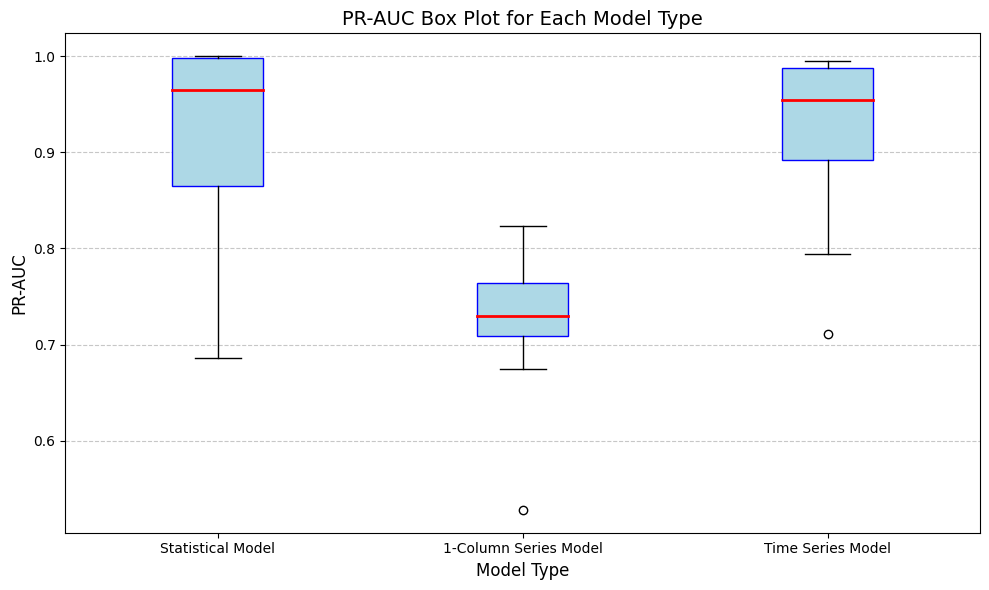

In [4]:
import matplotlib.pyplot as plt

# Prepare data for PR-AUC box plots
boxplot_data = {'stat': [], '1col': [], 'ts': []}

# Populate PR-AUC values for each model type
for model_name, result in results.items():
    model_type = model_name.split('_')[0]  # Extract model type
    boxplot_data[model_type].append(result['pr_auc'])

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(
    [boxplot_data['stat'], boxplot_data['1col'], boxplot_data['ts']],
    labels=['Statistical Model', '1-Column Series Model', 'Time Series Model'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red', linewidth=2)
)

# Add titles and labels
plt.title('PR-AUC Box Plot for Each Model Type', fontsize=14)
plt.ylabel('PR-AUC', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [28]:
# Prepare data for PR-AUC box plots
pr_auc_data = []

# Iterate over results and organize the data
for fh, table in output_tables.items():
    for index, row in table.iterrows():
        pr_auc_data.append({
            "Forecast Horizon (fh)": fh,
            "Model": row["Model"],
            "Window Size": row["Window Size"],
            "PR-AUC": row["PR-AUC"]
        })

# Convert to a DataFrame
df_pr_auc = pd.DataFrame(pr_auc_data)

df_pr_auc

,Forecast Horizon (fh),Model,Window Size,PR-AUC
0,2,stat,20,0.999608
1,2,stat,30,0.999208
2,2,ts,10,0.995306
3,2,ts,20,0.985537
4,2,ts,30,0.964958
5,2,stat,10,0.963168
6,2,stat,10,0.848491
7,2,1col,10,0.823492
8,2,ts,20,0.811741
9,2,ts,10,0.794711


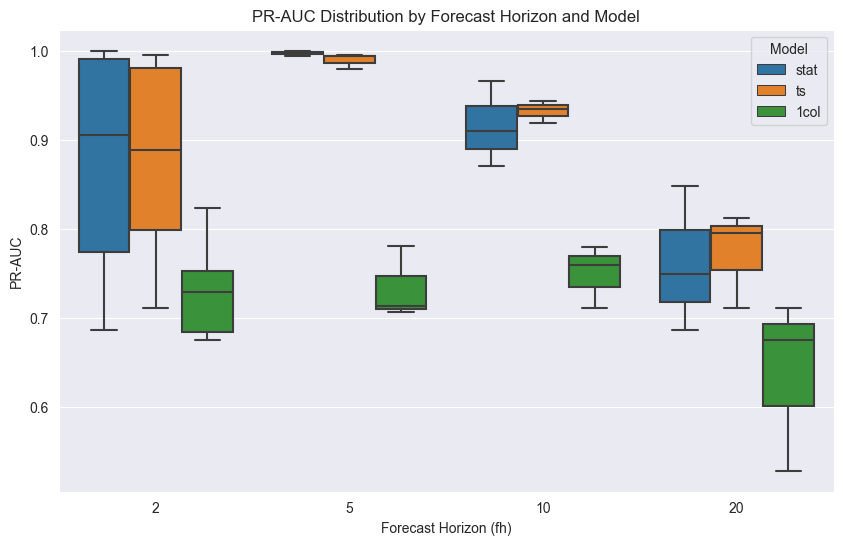

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("darkgrid")

# Create the box plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Forecast Horizon (fh)", y="PR-AUC", data=df_pr_auc, hue="Model", showfliers=False)

# Customize the plot
plt.title("PR-AUC Distribution by Forecast Horizon and Model")
plt.xlabel("Forecast Horizon (fh)")
plt.ylabel("PR-AUC")
plt.legend(title="Model")
plt.show()


In [30]:
# Prepare data for PR-AUC box plots
pr_auc_data = []

# Iterate over results and organize the data
for fh, table in output_tables.items():
    for index, row in table.iterrows():
        pr_auc_data.append({
            "Forecast Horizon (fh)": fh,
            "Model": row["Model"],
            "Window Size": row["Window Size"],
            "ROC-AUC": row["AUC"]
        })

# Convert to a DataFrame
df_pr_auc = pd.DataFrame(pr_auc_data)

df_pr_auc

,Forecast Horizon (fh),Model,Window Size,ROC-AUC
0,2,stat,20,0.999845
1,2,stat,30,0.999664
2,2,ts,10,0.998921
3,2,ts,20,0.994419
4,2,ts,30,0.977815
5,2,stat,10,0.975971
6,2,stat,10,0.880496
7,2,1col,10,0.880000
8,2,ts,20,0.840180
9,2,ts,10,0.825537



Evaluating 'stat' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Evaluating '1col' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5
  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20

Evaluating 'ts' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast 

KeyError: 'num_windows'


Evaluating 'stat' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20


c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\me.com\anaconda3\envs\elevator\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Evaluating '1col' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast Horizon (fh) = 20
  Window length = 30, Forecast Horizon (fh) = 2
  Window length = 30, Forecast Horizon (fh) = 5
  Window length = 30, Forecast Horizon (fh) = 10
  Window length = 30, Forecast Horizon (fh) = 20

Evaluating 'ts' model
  Window length = 10, Forecast Horizon (fh) = 2
  Window length = 10, Forecast Horizon (fh) = 5
  Window length = 10, Forecast Horizon (fh) = 10
  Window length = 10, Forecast Horizon (fh) = 20
  Window length = 20, Forecast Horizon (fh) = 2
  Window length = 20, Forecast Horizon (fh) = 5
  Window length = 20, Forecast Horizon (fh) = 10
  Window length = 20, Forecast 

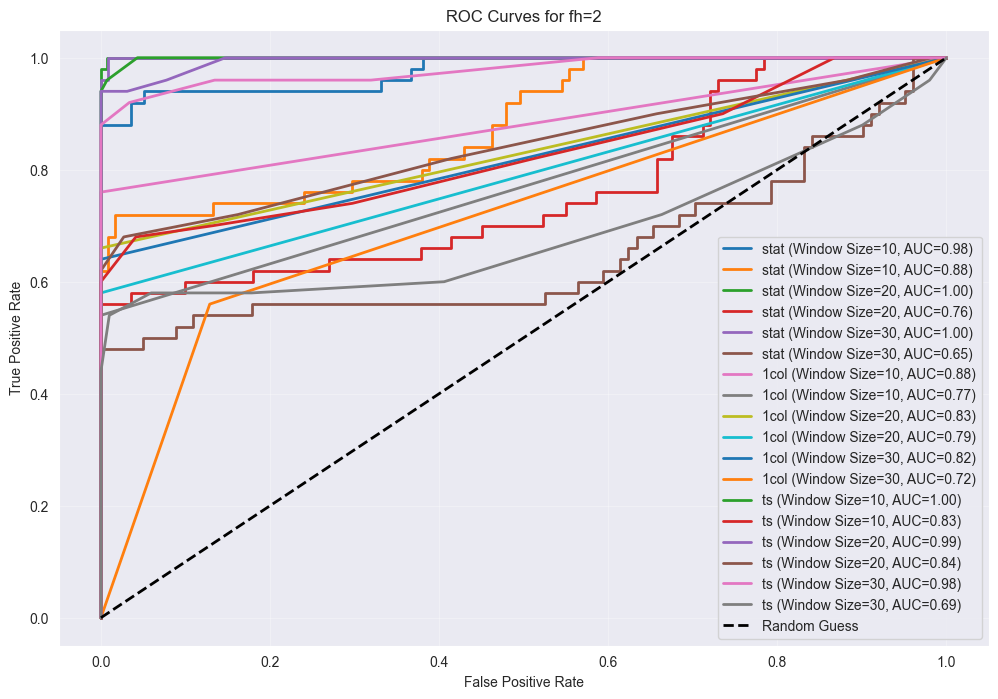

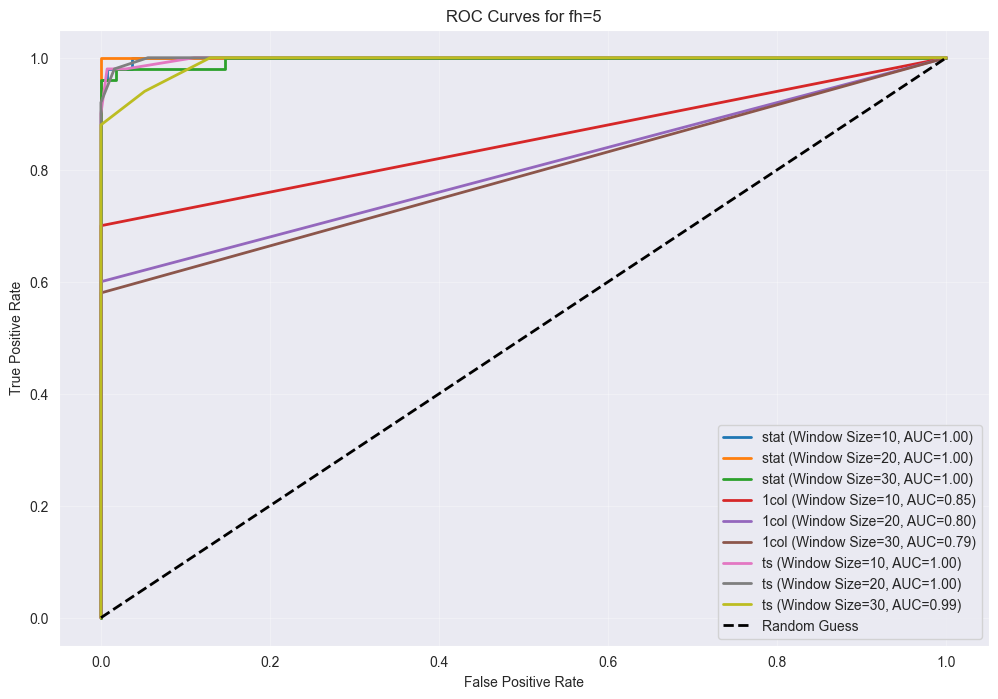

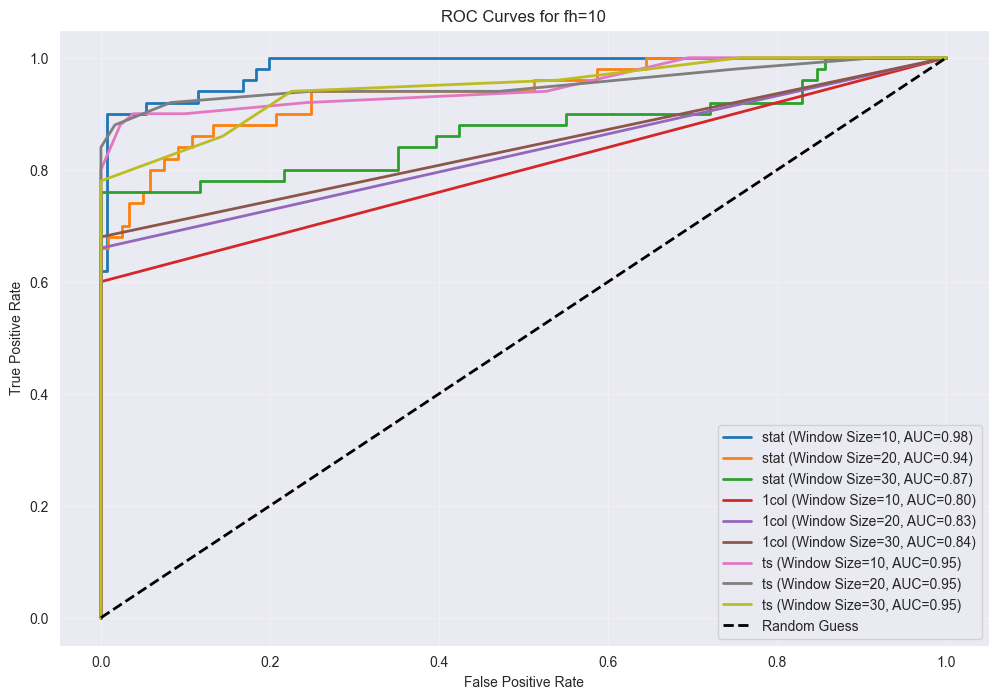

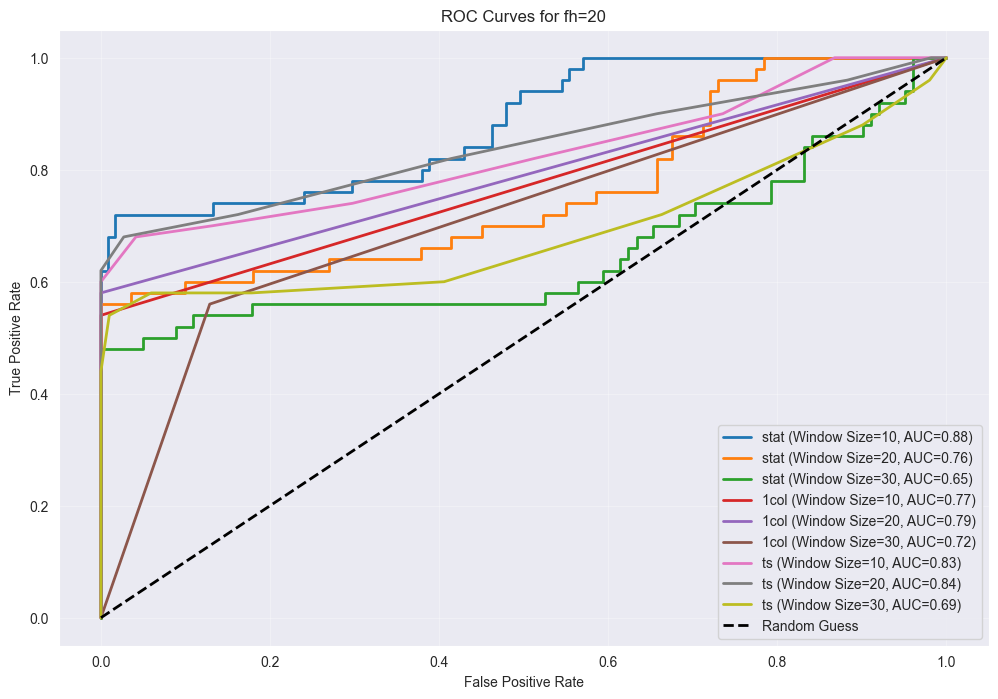

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc

from ml_pipeline.model import processing_pipeline, test_model
from ml_pipeline.featureset import make_summary_stats_input, make_series_input
from ml_pipeline.model import train_traditional_model, train_series_model, train_multiseries_model

# Load the data
train = pd.read_csv('../input/train/data.csv', parse_dates=['Time']).set_index('Time')
test = pd.read_csv('../input/test/data.csv', parse_dates=['Time']).set_index('Time')

# Dictionary to store all the data cuts we will create
data_dict = {'stat': {}, '1col': {}, 'ts': {}}

def evaluate_model(model_type, train_data, test_data, window_kwargs, feature_func, add_first_diffs, threshold=0.5):
    """
    Evaluates the model.

    model_type: str, one of 'stat', '1col', 'ts' to indicate the model type
    train_data: The data to train the model on (train or test slice of the dataset)
    test_data: The data to test the model on (test slice of the dataset)
    window_kwargs: A dictionary with window parameters for processing
    feature_func: The feature function to use (e.g., make_summary_stats_input, make_series_input)
    add_first_diffs: Boolean, whether to add first differences to the data
    threshold: float, decision threshold for classification
    """
    # Prepare the data using the processing pipeline for both training and testing sets
    X_train, y_train = processing_pipeline(
        train_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    X_test, y_test = processing_pipeline(
        test_data,
        window_kwargs=window_kwargs,
        feature_func=feature_func,
        add_first_diffs=add_first_diffs
    )
    
    # Calculate number of windows and lag
    num_windows = len(X_train)
    lag = window_kwargs['window_length']

    # Train the model
    if model_type == 'stat':
        model = train_traditional_model(X=X_train.values, y=y_train.values)
    elif model_type == '1col':
        model = train_series_model(X=X_train, y=y_train)
    elif model_type == 'ts':
        model = train_multiseries_model(X=X_train, y=y_train)

    # Predict and calculate performance using the provided test_model function
    test_results = test_model(X_test, y_test.values, model, threshold=threshold)

    # Calculate additional metrics: accuracy, AUC
    accuracy = accuracy_score(test_results['y_true'], test_results['y_pred'])
    auc_score = roc_auc_score(test_results['y_true'], test_results['class_1'])

    # Generate classification report for the model's performance
    report = classification_report(y_test.values, test_results['y_pred'], output_dict=True)
    
    # Compile results into a dictionary
    evaluation_results = {
        'classification_report': report,
        'accuracy': accuracy,
        'auc': auc_score,
        'num_windows': num_windows,
        'lag': lag,
        'roc_curve': (test_results['y_true'], test_results['class_1'])  # Store true labels and predicted probabilities for plotting
    }
    
    return evaluation_results

# Main execution to evaluate each model
results = {}

# Fix threshold to 0.5
threshold = 0.5

# Hyperparameter tuning for window_length and fh
window_length_candidates = [10, 20, 30]  # Adjust these values as needed
fh_candidates = [2, 5, 10, 20]  # Include specific fh values you are interested in

# Loop through different model types, window lengths, and fh values
for model_type in ['stat', '1col', 'ts']:
    print(f"\nEvaluating '{model_type}' model")
    for window_length in window_length_candidates:
        for fh in fh_candidates:
            window_kwargs = {'window_length': window_length, 'step_length': 1, 'fh': fh}
            print(f"  Window length = {window_length}, Forecast Horizon (fh) = {fh}")
            
            # Adjust feature function and first differences based on model type
            if model_type == 'stat':
                feature_func = make_summary_stats_input
                add_first_diffs = False
            elif model_type == '1col':
                feature_func = make_series_input
                add_first_diffs = False
            elif model_type == 'ts':
                feature_func = make_series_input
                add_first_diffs = True
            
            # Evaluate the model
            model_results = evaluate_model(
                model_type=model_type,
                train_data=train[-3100:-2900],
                test_data=test[4200:4400],
                window_kwargs=window_kwargs,
                feature_func=feature_func,
                add_first_diffs=add_first_diffs,
                threshold=threshold
            )
            
            # Store the results
            results[f'{model_type}_window_{window_length}_fh_{fh}'] = model_results

# Generate ROC curves for each `fh`
for fh in fh_candidates:
    plt.figure(figsize=(12, 8))
    for model_name, result in results.items():
        if f'_fh_{fh}' in model_name:  # Filter results for the current fh
            model_type = model_name.split('_')[0]
            window_size = model_name.split('_')[2].replace('window_', '')

            # Extract ROC curve data
            y_true, y_pred_probs = result['roc_curve']
            fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, label=f'{model_type} (Window Size={window_size}, AUC={roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for fh={fh}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
